## Initial notebook for project 

In [1]:
# Imports and set up
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torcheeg.io.eeg_signal import EEGSignalIO
from sklearn.model_selection import train_test_split

## Path to dir with data (remember the last '/')
path = "../data/"

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(path), io_mode='lmdb')
## Read metadata dataframeimports
metadata = pd.read_csv(path + 'sample_metadata.tsv', sep='\t')

In [2]:
from torch_geometric.nn import GCNConv

In [3]:
# Verifying connextion to data
idxs = np.arange(len(metadata))

X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
print(f"nsamples: {X.shape[0]}  -  nchannels: {X.shape[1]}  -  t: {X.shape[2]}")

y = torch.tensor(metadata["value"].values, dtype=torch.long)

nsamples: 5184  -  nchannels: 22  -  t: 800


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"shape of X train: {X_train.shape}")
print(f"shape of X val: {X_val.shape}")
print(f"shape of X test: {X_test.shape}")

print(f"shape of y train: {y_train.shape}")
print(f"shape of y val: {y_val.shape}")
print(f"shape of y test: {y_test.shape}")

shape of X train: torch.Size([3110, 22, 800])
shape of X val: torch.Size([1037, 22, 800])
shape of X test: torch.Size([1037, 22, 800])
shape of y train: torch.Size([3110])
shape of y val: torch.Size([1037])
shape of y test: torch.Size([1037])


In [5]:
#set up of matrixies 
#number of samples, channels, and timesteps
nsamples_train, nchannels_train, t = X_train.shape
nsamples_val, nchannels_val, t = X_val.shape

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

adj_matrix_train = torch.eye(nchannels_train)
adj_matrix_val = torch.eye(nchannels_val)

In [7]:
print(adj_matrix_train.shape)
print(type(adj_matrix_train))
print(nsamples_train)

print(adj_matrix_val.shape)
print(type(adj_matrix_val))
print(nsamples_val)

torch.Size([22, 22])
<class 'torch.Tensor'>
3110
torch.Size([22, 22])
<class 'torch.Tensor'>
1037


In [8]:
def get_adj_by_corr(data, nsamples, threshold=0.5):

    # Compute Pearson correlation between channels
    tmp_lst=[]
    
    for i in range(nsamples): 
        correlation_matrix = np.corrcoef(data[i])
        tmp_lst.append((correlation_matrix > threshold).astype(np.float32))
        
    # Convert correlation to adjacency matrix
    adj_mat = torch.from_numpy(np.array(tmp_lst))
    
    return adj_mat

In [48]:
class TrainCNN():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_loader, val_loader, learning_rate, w_decay=1e-4, epochs=100, prints=True):
        model = model.to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=w_decay)

        highest_train_accuracy = 0.0
        
        losses_train = []; losses_val = []

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0; running_loss_val = 0.0
            correct = 0; correct_val = 0
            total = 0; total_val = 0
            
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct/total
            losses_train.append(epoch_loss)
            
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss_val += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
            epoch_loss_val = running_loss_val / len(val_loader.dataset)
            epoch_accuracy_val = correct_val/total_val
            losses_val.append(epoch_loss_val)
                
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy

            if prints:
                print(f"Epoch {epoch+1}/{epochs}, Train loss: {epoch_loss:.4f}, Train acc: {(epoch_accuracy*100):.2f}%" +
                     f"| Val loss: {epoch_loss_val:.4f}, Val acc: {(epoch_accuracy_val*100):.2f}%")

        print(f"Highest Train Accuracy {(highest_train_accuracy*100):.2f}")
        torch.save(model.state_dict(), 'eeg_gnn.pth')
        
        losses = [losses_train, losses_val]

        return model, losses

In [56]:
class CNN2(nn.Module):
    
    def __init__(self, nclasses):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.3)
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.2)

        self.flattened_size = 128 * (800 // (2 * 2 * 2))
        #self.gap = nn.AdaptiveAvgPool1d(1)
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, nclasses)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1((self.conv1(x)))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2((self.conv2(x)))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3((self.conv3(x)))))
        x = self.dropout3(x)
        
        x = torch.flatten(x, 1)
        #x = self.gap(x)
        #x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [30]:
X_val[0].shape

torch.Size([22, 800])

In [60]:
nclasses = y.max().item() + 1 
model = CNN2(nclasses)

trainer = TrainCNN()
trained_model, losses = trainer.train_model(model, train_loader, val_loader, w_decay=1e-3,learning_rate=0.0001, epochs=40, prints=True)

Epoch 1/40, Train loss: 1.4257, Train acc: 27.11%| Val loss: 1.3748, Val acc: 30.18%
Epoch 2/40, Train loss: 1.3511, Train acc: 33.38%| Val loss: 1.3383, Val acc: 32.88%
Epoch 3/40, Train loss: 1.2977, Train acc: 37.72%| Val loss: 1.3104, Val acc: 37.42%
Epoch 4/40, Train loss: 1.2719, Train acc: 39.55%| Val loss: 1.3007, Val acc: 37.42%
Epoch 5/40, Train loss: 1.2497, Train acc: 42.06%| Val loss: 1.2946, Val acc: 36.84%
Epoch 6/40, Train loss: 1.2453, Train acc: 42.60%| Val loss: 1.3370, Val acc: 34.04%
Epoch 7/40, Train loss: 1.2186, Train acc: 43.95%| Val loss: 1.2781, Val acc: 36.45%
Epoch 8/40, Train loss: 1.2024, Train acc: 45.47%| Val loss: 1.3226, Val acc: 34.23%
Epoch 9/40, Train loss: 1.1793, Train acc: 46.43%| Val loss: 1.2728, Val acc: 36.55%
Epoch 10/40, Train loss: 1.1694, Train acc: 48.49%| Val loss: 1.3124, Val acc: 37.13%
Epoch 11/40, Train loss: 1.1536, Train acc: 49.77%| Val loss: 1.2563, Val acc: 37.32%
Epoch 12/40, Train loss: 1.1300, Train acc: 50.32%| Val loss: 1

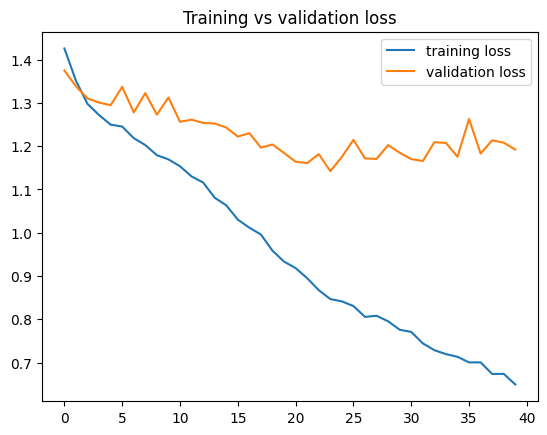

In [61]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(["training loss","validation loss"])
plt.title("Training vs validation loss");